In [1]:
#defaul libraries
#https://docs.python.org/ja/
import os
import sys
import io

import math
import random
import pprint
import time
import datetime
import typing
import json
import glob
import requests
import warnings
import gc
from pprint import pprint
import re

import numpy as np #https://numpy.org/
import pandas as pd #https://pandas.pydata.org/
import sklearn #https://scikit-learn.org/stable/

import matplotlib.pyplot as plt #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
from matplotlib import animation, rc
rc('animation', html='jshtml')
%matplotlib inline

import seaborn as sns
sns.set()

from tqdm.auto import tqdm #https://tqdm.github.io/

import torch #https://pytorch.org/

sys.path.append("../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D")
from efficientnet_pytorch_3d import EfficientNet3D

# import torchvision
import cv2
from PIL import Image

import pydicom

In [2]:
class CFG():
    
    data_path="../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
    debug=False
    seed=0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size=4
    epochs=10
    learning_rate=0.1
    kFold=5
    
    
    image_size=128

    #高速化関連
    #https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

    #GPU 遅くなるらしい↓
    torch.backends.cudnn.deterministic = True

    #イテレーションごとのnnの順伝搬および誤差関数の 計算手法がある程度一定であれば、torch.backends.cudnn.benchmark = Trueで GPU での計算が高速化
    #torch.backends.cudnn.benchmark = False


def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

print(CFG.device)
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())


cuda
0
Tesla P100-PCIE-16GB


In [3]:
def color(string,fg='DEFAULT',bg='DEFAULT',fg_rgb=None,bg_rgb=None,style='END'):
    colors=['BLACK','RED','GREEN','YELLOW','BLUE','PURPLE','CYAN','WHITE','8','DEFAULT']
    styles=['END','BOLD','2','3','UNDERLINE','5','6','REVERSE','INVISIBLE','9']

    fg=f'\033[3{colors.index(fg)}m'
    bg=f'\033[4{colors.index(bg)}m'
    style=f'\033[0{styles.index(style)}m'

    if fg_rgb:fg=f"\033[38;2;{fg_rgb[0]};{fg_rgb[1]};{fg_rgb[2]}m"
    if bg_rgb:bg=f"\033[48;2;{bg_rgb[0]};{bg_rgb[1]};{bg_rgb[2]}m"

    return style+fg+bg+str(string)+'\033[0m'

In [4]:
labels={'test':None}
labels['test']=pd.read_csv(os.path.join(CFG.data_path,"sample_submission.csv"),index_col='BraTS21ID')
if CFG.debug:
    labels['test']=labels['test'].sample(frac=0.1)

In [5]:
labels['test']["path"] = [
    os.path.join(*[CFG.data_path,'test',str(index).zfill(5)]) for index in labels['test'].index
]

In [6]:
labels['test']

,MGMT_value,path
BraTS21ID,,
1,0.5,../input/rsna-miccai-brain-tumor-radiogenomic-...
13,0.5,../input/rsna-miccai-brain-tumor-radiogenomic-...
15,0.5,../input/rsna-miccai-brain-tumor-radiogenomic-...
27,0.5,../input/rsna-miccai-brain-tumor-radiogenomic-...
37,0.5,../input/rsna-miccai-brain-tumor-radiogenomic-...
...,...,...
826,0.5,../input/rsna-miccai-brain-tumor-radiogenomic-...
829,0.5,../input/rsna-miccai-brain-tumor-radiogenomic-...
833,0.5,../input/rsna-miccai-brain-tumor-radiogenomic-...


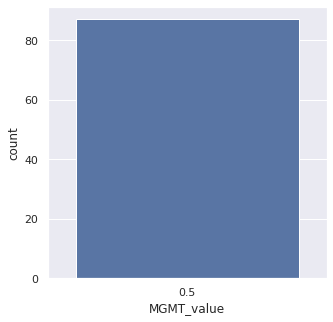

In [7]:
plt.figure(figsize=(5, 5))
sns.countplot(data=labels['test'], x="MGMT_value");

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,labels,phase='train',image_size=None):
        self.labels=labels
        self.phase=phase #train/val/test
        self.remove_black_boundary=True
        self.image_size=image_size
        
    def __len__(self):
        return len(self.labels)
    
    def images_path(self,BraTS21ID):
        """BraTS21ID に対応する患者のMRI画像のpathをまとめた DataFrame を返す"""
        df={"FLAIR":None,"T1w":None,"T1wCE":None,"T2w":None}
        for mri_type in ["FLAIR","T1w","T1wCE","T2w"]:
            #print(os.path.join(self.labels.loc[BraTS21ID].path,mri_type))
            folder_path=os.path.join(self.labels.loc[BraTS21ID].path,mri_type)
            dcm_files = os.listdir(folder_path)
            tmp_df = pd.DataFrame(
                {'image_path':[os.path.join(folder_path,dcm_file) for dcm_file in dcm_files]},
                index=[int(re.search('(\d+)',a).group()) for a in dcm_files],
            )
            tmp_df.sort_index(inplace=True)
            df[mri_type]=tmp_df
        return df
    
    def load_dicom(self,path,voi_lut=True,remove_black_boundary=True):
        """path で指定した MRI画像 を返す"""
        dicom = pydicom.read_file(path)
        data = dicom.pixel_array
        
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:data = pydicom.pixel_data_handlers.util.apply_voi_lut(data, dicom)#??????????????
        
        # depending on this value, X-ray may look inverted - fix that:
        if dicom.PhotometricInterpretation == "MONOCHROME1":
            print('inverted')
            data = np.amax(data) - data
        
        data=data.astype(np.float32)
        data = data-np.min(data)
        if np.max(data)!=0 : data/=np.max(data)
        #data = (data * 255).astype(np.uint8)
        return cv2.resize(data, (CFG.image_size, CFG.image_size))

    def __getitem__(self,BraTS21ID):
        #print(f'fetching:{BraTS21ID}')
        df=self.images_path(BraTS21ID)
        mri_images={
            "FLAIR":np.ndarray((0,CFG.image_size,CFG.image_size),dtype=np.int),
            "T1w"  :np.ndarray((0,CFG.image_size,CFG.image_size),dtype=np.int),
            "T1wCE":np.ndarray((0,CFG.image_size,CFG.image_size),dtype=np.int),
            "T2w"  :np.ndarray((0,CFG.image_size,CFG.image_size),dtype=np.int)
        }
        #3次元ndarrayに画像を一枚ずつ追加
        for mri_type in ["FLAIR","T1w","T1wCE","T2w"]:
            
            #plane決定
            ImageOrientationPatient=pydicom.read_file(df[mri_type].image_path.iloc[0]).get('ImageOrientationPatient')
            ImageOrientationPatient=np.round(ImageOrientationPatient)[[0,1,3,4]]
            
            orientation='unknown'
            if (ImageOrientationPatient==[1,0,0,0]).all():orientation="Coronal"
            if (ImageOrientationPatient==[0,1,0,0]).all():orientation="Sagittal"
            if (ImageOrientationPatient==[1,0,0,1]).all():orientation="Axial"
            #print(orientation)

            #画像まとめる
            for image_path in df[mri_type].image_path:
                image=self.load_dicom(image_path)
                image=np.reshape(image,(1,CFG.image_size,CFG.image_size)) # reshapeで追加先と同じ次元数にする
                mri_images[mri_type] = np.append(mri_images[mri_type], np.atleast_3d(image), axis=0)
            
                
            #真っ黒な画像　＆　周りの黒い領域を消す
            #self.remove_black_boundary:
            t,x,y=np.where(mri_images[mri_type]>0)
            ###train 123 T1w T2w 真っ暗
            if (len(t) == 0 or len(x) == 0 or len(y) == 0) : pass
            #if self.frame_per_brain and (np.max(t) - np.min(t)) < self.frame_per_brain : pass
            #if (np.max(x) - np.min(x)) < 10 : pass
            #if (np.max(y) - np.min(y)) < 10 : pass
            mri_images[mri_type]=mri_images[mri_type][np.min(t):np.max(t),np.min(x):np.max(x),np.min(y):np.max(y)]

            
            #xかyに合わせて拡大 (脳の前後を画像サイズに合わせる) coronalの場合は80%
            t,x,y=np.shape(mri_images[mri_type])
            enlarged_x=int(x/max(x,y)*CFG.image_size*(1 if orientation!='Coronal' else 0.8))
            enlarged_y=int(y/max(x,y)*CFG.image_size*(1 if orientation!='Coronal' else 0.8))

            enlarged_mri_images = np.zeros((t,enlarged_x,enlarged_y))
            for idx,image in enumerate(mri_images[mri_type]):
                enlarged_mri_images[idx,:,:] = cv2.resize(image.astype('float32') ,(enlarged_y,enlarged_x),interpolation=cv2.INTER_CUBIC)
            mri_images[mri_type]=enlarged_mri_images

            
            #時間軸の画像枚数を変換
            image_t_num=self.image_size
            if orientation=='Sagittal':image_t_num=int(image_t_num*0.8)
            modified_mri_images = np.zeros((
                image_t_num,
                np.shape(mri_images[mri_type])[1],
                np.shape(mri_images[mri_type])[2],
            ))
            
            for i in range(image_t_num):
                frame=(np.shape(mri_images[mri_type])[0]-1)/(image_t_num-1)*i
                rate=frame-int(frame)
                #print(i,frame,rate)

                if abs(rate)<1e-5:modified_mri_images[i,:,:]=mri_images[mri_type][int(frame)]
                else:modified_mri_images[i,:,:]=mri_images[mri_type][int(frame)]*(1-rate)+mri_images[mri_type][int(frame)+1]*rate#

            mri_images[mri_type]=modified_mri_images
            
            #Axialになるよう反転
            #print(np.shape(mri_images[mri_type]))
            if orientation=='Axial':mri_images[mri_type]=np.flip(mri_images[mri_type],0)
            if orientation=='Sagittal':mri_images[mri_type]=np.flip(mri_images[mri_type].transpose(1,2,0),2)
            if orientation=='Coronal':mri_images[mri_type]=np.flip(mri_images[mri_type].transpose(1,0,2),1)
                
            #反転後の時間軸の画像枚数を調整
            modified_mri_images = np.zeros((
                self.image_size,
                np.shape(mri_images[mri_type])[1],
                np.shape(mri_images[mri_type])[2],
            ))

            for i in range(self.image_size):
                frame=(np.shape(mri_images[mri_type])[0]-1)/(self.image_size-1)*i
                rate=frame-int(frame)
                #print(i,frame,rate)

                if abs(rate)<1e-5:modified_mri_images[i,:,:]=mri_images[mri_type][int(frame)]
                else:modified_mri_images[i,:,:]=mri_images[mri_type][int(frame)]*(1-rate)+mri_images[mri_type][int(frame)+1]*rate##

            mri_images[mri_type]=modified_mri_images


            #切り取ったあと周りを追加して256×256に
            t,x,y=np.shape(mri_images[mri_type])
            padding=[
                ((CFG.image_size-t)//2,(CFG.image_size-t+1)//2),#(0,0),
                ((CFG.image_size-x)//2,(CFG.image_size-x+1)//2),
                ((CFG.image_size-y)//2,(CFG.image_size-y+1)//2)
            ]#paddingの大きさ
            mri_images[mri_type]=np.pad(mri_images[mri_type],padding,'constant')
            
            #min-max normalization
            ma=np.max(mri_images[mri_type])
            mi=np.min(mri_images[mri_type])
            mri_images[mri_type]=(mri_images[mri_type]-mi)/(ma-mi)
            
            mri_images[mri_type]=mri_images[mri_type][range(0,CFG.image_size,2)]
                
        return mri_images,self.labels.MGMT_value.loc[BraTS21ID]

In [9]:
dataset={
    'test':Dataset(labels['test'],'test',image_size=CFG.image_size),
}

In [10]:
class Sampler(torch.utils.data.Sampler):
    def __init__(self, indice):
        self.indice=indice
    def __iter__(self):
        for index in self.indice:yield index

def collate_fn(batch):
    #print("collate_fn")
    mri_images,MGMT_value= list(zip(*batch))
    #mri_images[0]["FLAIR"]
    all_mri_images=[]#(4,frame_per_brain,256,256)のtensorのリスト
    
    for idx in range(len(MGMT_value)):
        mri_image_tensor=[]
        for mri_type in ["FLAIR","T1w","T1wCE","T2w"]:
            mri_image_tensor.append(torch.tensor(mri_images[idx][mri_type]))
        all_mri_images.append(torch.stack(mri_image_tensor))

    batch_image=all_mri_images[0].unsqueeze(0) if len(all_mri_images)==1 else torch.stack(all_mri_images)
    #(batch_size,4,frame_per_brain,256,256)
    return batch_image.float(),torch.tensor(MGMT_value).float()

def set_dataloader():
    global dataloader
    dataloader={
        'test':
        torch.utils.data.DataLoader(
            dataset['test'],
            batch_size=CFG.batch_size,
            sampler=Sampler(list(labels['test'].index)),
            collate_fn=collate_fn,
            num_workers=2,#os.cpu_count(),
            pin_memory=True
        )
    }
set_dataloader()

In [11]:
# class Model(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.FLAIR = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
#         self.T1w   = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
#         self.T1wCE = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
#         self.T2w   = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
#         n_features = self.FLAIR._fc.in_features
#         self.FLAIR._fc  = torch.nn.Linear(in_features=n_features, out_features=1, bias=True)
#         self.T1w._fc    = torch.nn.Linear(in_features=n_features, out_features=1, bias=True)
#         self.T1wCE._fc = torch.nn.Linear(in_features=n_features, out_features=1, bias=True)
#         self.T2w._fc    = torch.nn.Linear(in_features=n_features, out_features=1, bias=True)
        
#         self.fc    = torch.nn.Linear(in_features=4, out_features=1, bias=True)
        
#         #self.sigmoid=torch.nn.Sigmoid()
        
    
#     def forward(self, x):
        
#         #x (batch_size,channel,x,y,z)?
#         out1 = self.FLAIR(x[:,0,:,:,:].unsqueeze(1))
#         out2 = self.T1w(x[:,1,:,:,:].unsqueeze(1))
#         out3 = self.T1wCE(x[:,2,:,:,:].unsqueeze(1))
#         out4 = self.T2w(x[:,3,:,:,:].unsqueeze(1))
        
# #         print(out1.shape)
# #         print(torch.cat((out1,out2,out3,out4),-1))
#         return self.fc(torch.cat((out1,out2,out3,out4),-1))

    
# model=Model()
# model.to(CFG.device)
# model.load_state_dict(torch.load('../input/brain-tumor-radiogenomic-classification/4models.pt'))

In [12]:
model=EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
n_features = model._fc.in_features
model._fc = torch.nn.Linear(in_features=n_features, out_features=1, bias=True)
model.to(CFG.device)

model.load_state_dict(torch.load('../input/brain-tumor-radiogenomic-classification/model_ver32.pt'))

<All keys matched successfully>

In [13]:
def test(model,dataloader,ch_num=4):# モデルを学習させる関数
    
    #assert((phase=='train')==bool(optimizer))#学習時にoptimizer必須
    torch.no_grad()#model.eval()   # モデルのモード

    y=[]
    preds=[]
    losses=[]
    scores=[]

#     print('preprocess images')
#     #preprocessed=list(dataloader[phase])
#     print('end')

    # データローダーからミニバッチを取り出すループ
    for images,targets in tqdm(dataloader['test']):

        #print(images.shape)

        if images.shape[0]==1:
            #なぜかバッチサイズが1になるとバグる
            print('batchsize==1')
            preds.append(0.5)
            continue


        # 順伝搬（forward）計算
        with torch.set_grad_enabled(False):
            
            if ch_num==1:
                images=images[:,0,:,:,:].unsqueeze(1)

#             with torch.cuda.amp.autocast():#HalfTensorになる？

            # non_blocking=TrueでPinned MemoryからGPUに転送中もCPUが動作できるらしい。
            images = images[:,0,:,:,:].unsqueeze(1).to(CFG.device,non_blocking=True)#[:,0,:,:,:].unsqueeze(1)
            targets = targets.to(CFG.device,non_blocking=True)

            outputs = model(images).squeeze(1)

        preds.extend(torch.nn.Sigmoid()(outputs).detach().cpu().numpy())
        y.extend(targets.detach().cpu().numpy())

        del images,targets,outputs
        torch.cuda.empty_cache()
        gc.collect()

    return preds,losses,scores


In [14]:
# #set_dataloader()

# predictions=pd.DataFrame()

# preds,losses,scores=test(model,dataloader)

# predictions['4ch']=preds

# model=EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
# n_features = model._fc.in_features
# model._fc = torch.nn.Linear(in_features=n_features, out_features=1, bias=True)
# model.to(CFG.device)


# model.load_state_dict(torch.load('../input/brain-tumor-radiogenomic-classification/model.pt'))

# preds,losses,scores=test(model,dataloader,ch_num=1)
# predictions['1ch']=preds

# model.load_state_dict(torch.load('../input/brain-tumor-radiogenomic-classification/model (1).pt'))

# preds,losses,scores=test(model,dataloader,ch_num=1)
# predictions['1ch_ver2']=preds

In [15]:
# predictions['sum']=predictions['4ch']+predictions['1ch']+predictions['1ch_ver2']
# predictions['sum']=predictions['sum']/3

In [16]:
# predictions

In [17]:
preds,losses,scores=test(model,dataloader)

0it [00:00, ?it/s]

In [18]:
#preds=[1.0]*87
submission=labels['test'].drop('path',axis=1)

submission['MGMT_value']=preds
submission.to_csv("submission.csv",index='BraTS21ID')
submission

,MGMT_value
BraTS21ID,
1,0.386466
13,0.804999
15,0.088822
27,0.325689
37,0.310758
...,...
826,0.500082
829,0.380193
833,0.379946
